In [6]:
#Libraries
import re
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers
from keras.models import Model

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [7]:
def processed_data(data):
    data=data.drop(columns=["Unnamed: 0"])
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [8]:
def DA_label_count(data):
    label_count=data.groupby('Basic')['Basic'].agg('count')
    label_count.to_numpy(dtype=int)
    label_count = np.expand_dims(label_count, axis=0)
    label_count.shape=(5,1)
    labels=np.array(['B', 'D', 'F', 'Q', 'S'])
    labels.shape=(5,1)
    label_count=np.column_stack((labels,label_count))
    df = pd.DataFrame(label_count, columns=['Label', 'Count'])
    convert_dict = {
                    'Label': str,
                    'Count': int
                   }  
    df = df.astype(convert_dict)
    return df

In [9]:
full_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\DAC\\datasets\\MRDA\\full_set.csv')
MAX_PADDING = 100
def x_value(data):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(full_data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    
    return x

In [11]:
train_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\DAC\\datasets\\MRDA\\train.csv')
train_data,y_train = processed_data(train_data)
x_train = x_value(train_data)

val_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\DAC\\datasets\\MRDA\\val.csv')
val_data,y_val = processed_data(val_data)
x_val = x_value(val_data)

test_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\DAC\\datasets\\MRDA\\test.csv')
test_data,y_test = processed_data(test_data)
x_test = x_value(test_data)

In [12]:
def prev_utt_generator(x):
    shape = x.shape 
    zeros = shape[1]
    zero_array = np.zeros((1, zeros))
    array = np.concatenate((zero_array, x))
    req_array = array[:-1]
    return req_array

In [13]:
x_train_prev = prev_utt_generator(x_train)
x_val_prev = prev_utt_generator(x_val)
x_test_prev = prev_utt_generator(x_test)

In [14]:
from keras.layers import Layer
import keras.backend as K

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [15]:
curr_utterance_input = Input(shape=(100), name='current_utterance_input')

curr_embedding = Embedding(input_dim=5000,
                           output_dim=300,
                           input_length=100,
                           embeddings_regularizer=keras.regularizers.l2(.001))(curr_utterance_input)

curr_bilstm = Bidirectional(LSTM(units=20,
                            dropout=0.3,
                            recurrent_dropout=0.2,
                            return_sequences = True))(curr_embedding)

#attention on word level(on a single utterance)
utt_attention = attention()(curr_bilstm)

curr_output=Dense(5)(utt_attention) 


#Context of previous utterance
prev_utterance_input = Input(shape=(100,), name='previous_utterance_input')

prev_embedding =Embedding(input_dim=5000,
                          output_dim=300,
                          input_length=100,
                          embeddings_regularizer=keras.regularizers.l2(.001))(prev_utterance_input)

prev_bilstm =Bidirectional(LSTM(units=20,
                                dropout=0.3,
                                recurrent_dropout=0.2,
                                return_sequences = False))(prev_embedding)

prev_output=Dense(5)(prev_bilstm) 


concat = concatenate([curr_output, prev_output], name='Concatenate')

reshape = Reshape((-1, 10))(concat)

context_attention = attention()(reshape)

final_model_output = Dense(5, activation='softmax')(context_attention)

final_model = Model(inputs=[prev_utterance_input, curr_utterance_input],
                    outputs=final_model_output,
                    name='Final_output')

In [16]:
final_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
final_model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 current_utterance_input (Input  [(None, 100)]       0           []                               
 Layer)                                                                                           
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     1500000     ['current_utterance_input[0][0]']
                                                                                                  
 previous_utterance_input (Inpu  [(None, 100)]       0           []                               
 tLayer)                                                                                          
                                                                                       

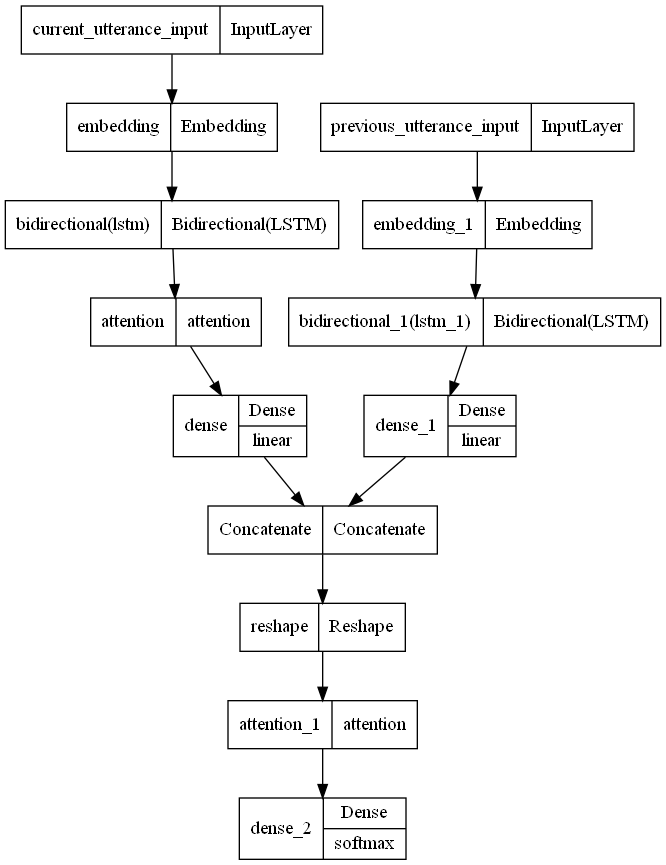

In [17]:
tf.keras.utils.plot_model(
    final_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=3, 
                                               verbose=1)

In [21]:
hist = final_model.fit([x_train, x_train_prev], y_train, 
                       epochs=100, 
                       batch_size=32, 
                       verbose=1,
                       callbacks=[early_stopping],
                       validation_data=([x_val,x_val_prev], y_val) )

Epoch 1/100
2346/2346 [==============================] - 840s 358ms/step - loss: 0.7243 - accuracy: 0.7555 - val_loss: 0.7539 - val_accuracy: 0.7518
Epoch 2/100
2346/2346 [==============================] - 919s 392ms/step - loss: 0.6644 - accuracy: 0.7779 - val_loss: 0.7089 - val_accuracy: 0.7599
Epoch 3/100
2346/2346 [==============================] - 1059s 452ms/step - loss: 0.6529 - accuracy: 0.7823 - val_loss: 0.7007 - val_accuracy: 0.7652
Epoch 4/100
2346/2346 [==============================] - 1260s 537ms/step - loss: 0.6459 - accuracy: 0.7864 - val_loss: 0.7169 - val_accuracy: 0.7609
Epoch 5/100
2346/2346 [==============================] - 1128s 481ms/step - loss: 0.6418 - accuracy: 0.7869 - val_loss: 0.6954 - val_accuracy: 0.7702
Epoch 6/100
2346/2346 [==============================] - 1226s 523ms/step - loss: 0.6391 - accuracy: 0.7892 - val_loss: 0.7033 - val_accuracy: 0.7669
Epoch 7/100
2346/2346 [==============================] - 1181s 503ms/step - loss: 0.6358 - accuracy: 0

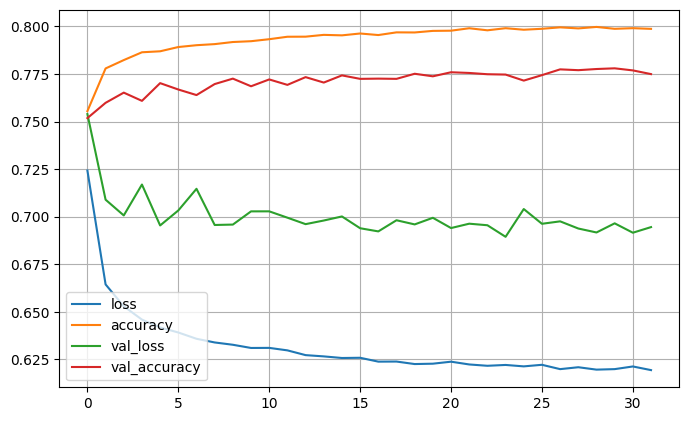

In [22]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 100


def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

plot(hist)

In [23]:
final_model.evaluate([x_test, x_test_prev], y_test)

522/522 [==============================] - 178s 342ms/step - loss: 0.6497 - accuracy: 0.7838


[0.6497000455856323, 0.7838453054428101]

In [25]:
DA = np.array(['B','D','F','Q','S'])
a = ["who are you",
     "I am Rahul"]
tokenizer = Tokenizer(num_words = 5000, split=" ")
#full_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\full_set.csv')
tokenizer.fit_on_texts(full_data['Utterances'].values)
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=100)
a_prev = prev_utt_generator(a)
print(a_prev.shape)
prediction = final_model.predict([a,a_prev])
print(DA[prediction.argmax(1)])

C:\Users\user1\AppData\Local\Temp/ipykernel_6732/662998522.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(a)


(2, 100)
['Q' 'S']
